# Imports

In [ ]:
import numpy as np
import pandas as pd
import gzip

import re 
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')    # review_length 생성시 필요
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from datetime import datetime

## Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/appliances_cleaned.csv')

In [ ]:
df.isnull().sum()

rating                  0
reviewer_id             0
product_id              0
unix_review_time        0
category                0
description             0
also_buy                0
brand                4520
main_cat              249
price               96507
review_text             0
rating_class            0
time                    0
dtype: int64

# 텍스트 전처리

In [ ]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [ ]:
temp = []
data_to_list = df['review_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Matched pigtail cord and works great. Just what I needed for my electric range. Matched pigtail cord and works great.',
 'complete package I like the fact that the wire ends have mounting tips assembled and that the cord has a strain relief clamp included. Id recommend this to any diy person',
 'Perfect Fit Needed another couple of feet with new dryer, perfect fit. Gives you more options then the shorter cords normally sold.',
 'Everything works Good quality at a reasonable price',
 '50 amp cable Planning on hooking this to my RV']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['matched', 'pigtail', 'cord', 'and', 'works', 'great', 'just', 'what', 'needed', 'for', 'my', 'electric', 'range', 'matched', 'pigtail', 'cord', 'and', 'works', 'great'], ['complete', 'package', 'like', 'the', 'fact', 'that', 'the', 'wire', 'ends', 'have', 'mounting', 'tips', 'assembled', 'and', 'that', 'the', 'cord', 'has', 'strain', 'relief', 'clamp', 'included', 'id', 'recommend', 'this', 'to', 'any', 'diy', 'person'], ['perfect', 'fit', 'needed', 'another', 'couple', 'of', 'feet', 'with', 'new', 'dryer', 'perfect', 'fit', 'gives', 'you', 'more', 'options', 'then', 'the', 'shorter', 'cords', 'normally', 'sold'], ['everything', 'works', 'good', 'quality', 'at', 'reasonable', 'price'], ['amp', 'cable', 'planning', 'on', 'hooking', 'this', 'to', 'my', 'rv'], ['good', 'range', 'cord', 'standard', 'nema', 'fits', 'with', 'nema', 'this', 'product', 'is', 'pretty', 'simple', 'one', 'do', 'like', 'prettymuch', 'any', 'product', 'made', 'by', 'southwire', 'they', 'make', 'good', 'stuff', '

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['matched pigtail cord and works great just what needed for my electric range matched pigtail cord and works great', 'complete package like the fact that the wire ends have mounting tips assembled and that the cord has strain relief clamp included id recommend this to any diy person', 'perfect fit needed another couple of feet with new dryer perfect fit gives you more options then the shorter cords normally sold', 'everything works good quality at reasonable price', 'amp cable planning on hooking this to my rv']


In [ ]:
df['clean_text'] = data

In [ ]:
df.head()

,rating,reviewer_id,product_id,unix_review_time,category,description,also_buy,brand,main_cat,price,review_text,rating_class,time,clean_text
0,5,A3SHVDMM83IHJ4,B00002N7IL,1426809600,"['Appliances', 'Parts & Accessories', 'Range P...",['Outfit your dryer with top-notch connections...,"['B000FK9X6W', 'B000BPFZHM', 'B000FP8LK6', 'B0...",Leviton,Tools & Home Improvement,NaN,Matched pigtail cord and works great. Just wha...,good,2015-03-20,matched pigtail cord and works great just what...
1,5,A2OXDRWBASV91Y,B00004SQHD,1366416000,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,complete package I like the fact that the wire...,good,2013-04-20,complete package like the fact that the wire e...
2,5,A2KG6AWJSWILPR,B00004SQHD,1363392000,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,Perfect Fit Needed another couple of feet with...,good,2013-03-16,perfect fit needed another couple of feet with...
3,5,A2CBE6VYOARZN4,B00004SQHD,1487030400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,Everything works Good quality at a reasonable ...,good,2017-02-14,everything works good quality at reasonable price
4,5,AVKOTZD5ZIOX5,B00004SQHD,1482278400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,50 amp cable Planning on hooking this to my RV,good,2016-12-21,amp cable planning on hooking this to my rv


# 필요한 컬럼 생성.
review_lenth, year

In [ ]:
# year 컬럼 추가
# time 컬럼을 datetime 타입으로 변환 후 연도만 빼서 year 컬럼 추가
df['time'] = pd.to_datetime(df['time'], format = '%Y-%m-%d')
df['year'] = df['time'].dt.year

In [ ]:
# review_length 컬럼 추가
def length(text):
    length = len([w for w in nltk.word_tokenize(text)])
    return length
df['review_length'] = df['review_text'].apply(length)
df.head()

,rating,reviewer_id,product_id,unix_review_time,category,description,also_buy,brand,main_cat,price,review_text,rating_class,time,clean_text,year,review_length
0,5,A3SHVDMM83IHJ4,B00002N7IL,1426809600,"['Appliances', 'Parts & Accessories', 'Range P...",['Outfit your dryer with top-notch connections...,"['B000FK9X6W', 'B000BPFZHM', 'B000FP8LK6', 'B0...",Leviton,Tools & Home Improvement,NaN,Matched pigtail cord and works great. Just wha...,good,2015-03-20,matched pigtail cord and works great just what...,2015,23
1,5,A2OXDRWBASV91Y,B00004SQHD,1366416000,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,complete package I like the fact that the wire...,good,2013-04-20,complete package like the fact that the wire e...,2013,33
2,5,A2KG6AWJSWILPR,B00004SQHD,1363392000,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,Perfect Fit Needed another couple of feet with...,good,2013-03-16,perfect fit needed another couple of feet with...,2013,25
3,5,A2CBE6VYOARZN4,B00004SQHD,1487030400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,Everything works Good quality at a reasonable ...,good,2017-02-14,everything works good quality at reasonable price,2017,8
4,5,AVKOTZD5ZIOX5,B00004SQHD,1482278400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,50 amp cable Planning on hooking this to my RV,good,2016-12-21,amp cable planning on hooking this to my rv,2016,10


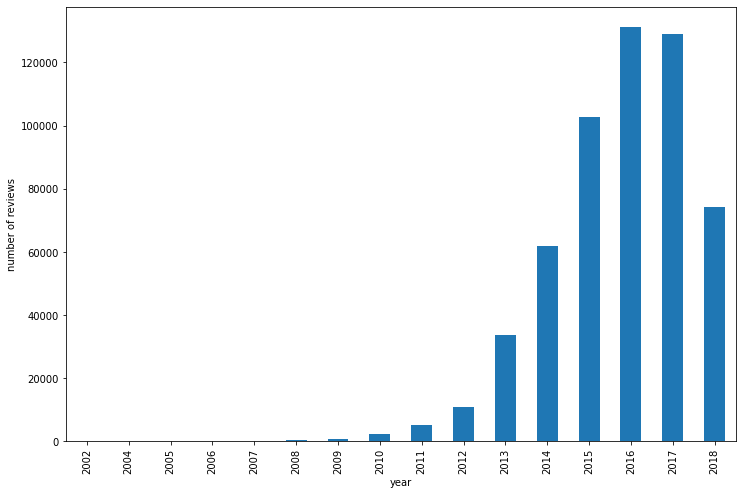

In [ ]:
# 연도별 리뷰개수 분포
plt.figure(figsize=(12, 8))
df['year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('year')
plt.ylabel('number of reviews')
plt.show()

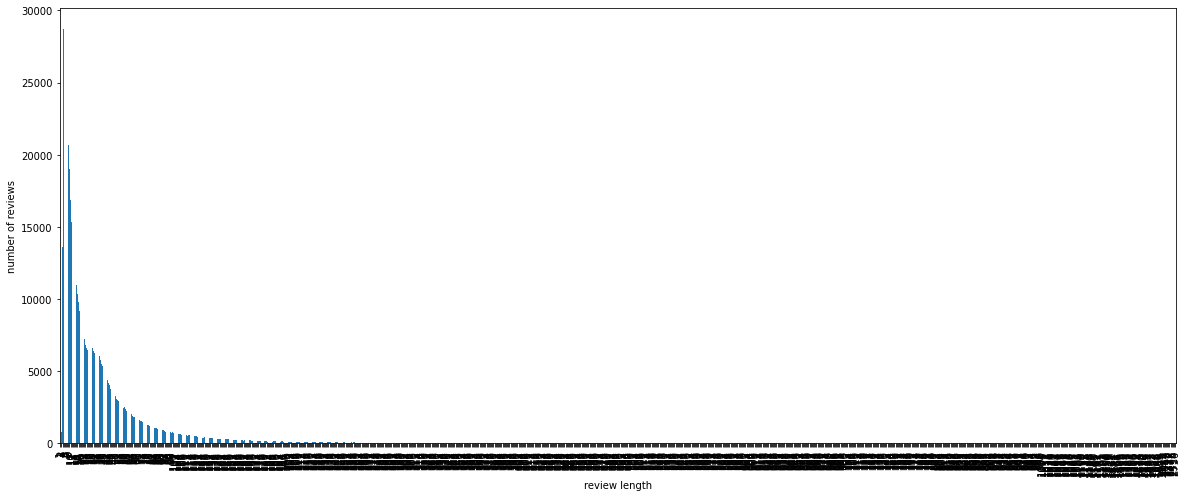

In [ ]:
# 리뷰 길이별 리뷰 개수 분포
plt.figure(figsize=(20, 8))
df['review_length'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('review length')
plt.ylabel('number of reviews')
plt.show()

In [ ]:
df['review_length'].describe()

count    552342.000000
mean         37.629516
std          56.944666
min           1.000000
25%           9.000000
50%          21.000000
75%          44.000000
max        2750.000000
Name: review_length, dtype: float64

## Data Analysis

Text(0, 0.5, 'number of reviews')

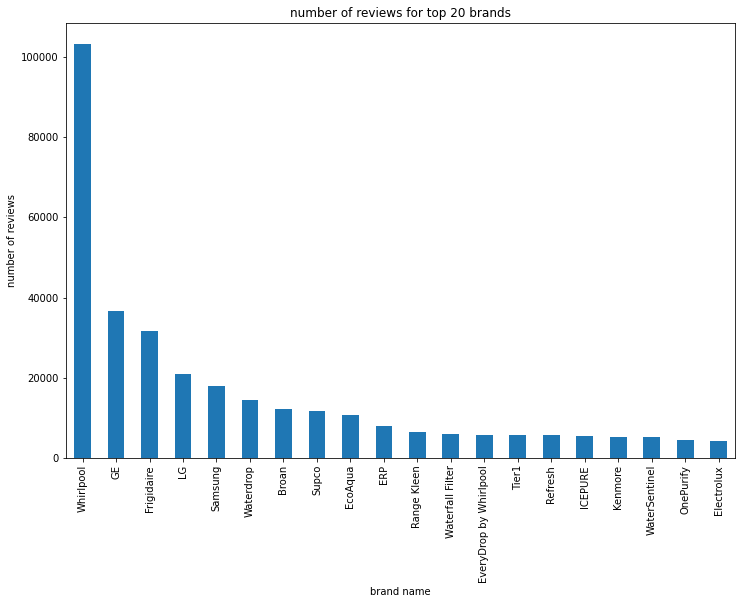

In [ ]:
# plot number of reviews for top 20 brands

brands = df['brand'].value_counts()
plt.figure(figsize=(12, 8))
brands[:20].plot(kind='bar')
plt.title('number of reviews for top 20 brands')
plt.xlabel('brand name')
plt.ylabel('number of reviews')

Text(0, 0.5, 'number of reviews')

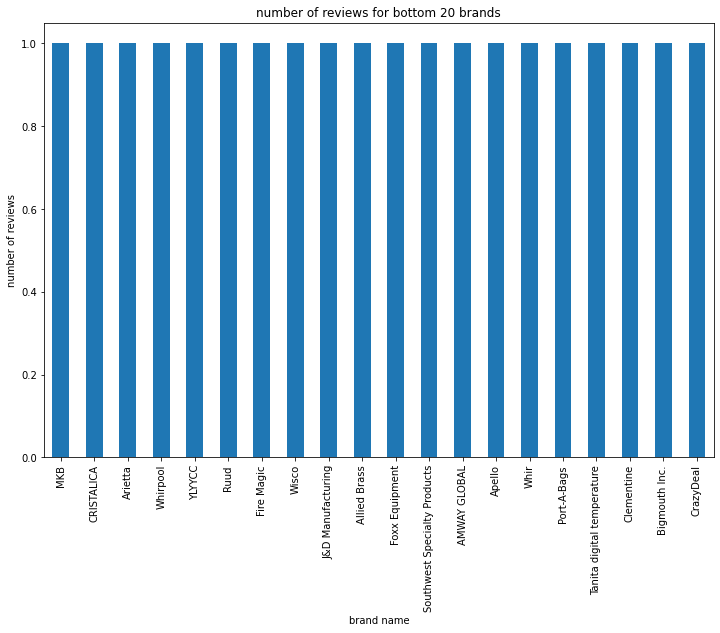

In [ ]:
# plot number of reviews for bottom 20 brands

plt.figure(figsize=(12, 8))
brands[-20:].plot(kind='bar')
plt.title('number of reviews for bottom 20 brands')
plt.xlabel('brand name')
plt.ylabel('number of reviews')

In [ ]:
df['time'] = pd.to_datetime(df['time'], format = '%Y-%m-%d')

In [ ]:
df['time']

0        2015-03-20
1        2013-04-20
2        2013-03-16
3        2017-02-14
4        2016-12-21
            ...    
552337   2017-08-10
552338   2018-08-01
552339   2018-04-13
552340   2018-03-23
552341   2018-01-08
Name: time, Length: 552342, dtype: datetime64[ns]

In [ ]:
# rating and reviews - 임의로 상품 선택
prod = df[(df['brand'] == 'Coleman Cable')]
prod.head()

,rating,reviewer_id,product_id,unix_review_time,category,description,also_buy,brand,main_cat,price,review_text,rating_class,time,clean_text,year,review_length
1,5,A2OXDRWBASV91Y,B00004SQHD,1366416000,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,complete package I like the fact that the wire...,good,2013-04-20,complete package like the fact that the wire e...,2013,33
2,5,A2KG6AWJSWILPR,B00004SQHD,1363392000,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,Perfect Fit Needed another couple of feet with...,good,2013-03-16,perfect fit needed another couple of feet with...,2013,25
3,5,A2CBE6VYOARZN4,B00004SQHD,1487030400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,Everything works Good quality at a reasonable ...,good,2017-02-14,everything works good quality at reasonable price,2017,8
4,5,AVKOTZD5ZIOX5,B00004SQHD,1482278400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,50 amp cable Planning on hooking this to my RV,good,2016-12-21,amp cable planning on hooking this to my rv,2016,10
5,5,A33DUVUIC7G553,B00004SQHD,1460678400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,"Good range cord, standard nema 14-50p fits wit...",good,2016-04-15,good range cord standard nema fits with nema t...,2016,137


In [ ]:
# 해당 상품에 대한 가격별 별점
date_rate = prod.groupby(['price'])['rating'].mean()
date_rate

price
$1.41     4.612903
$12.18    4.000000
$12.85    4.689655
$13.87    4.787879
$18.55    5.000000
Name: rating, dtype: float64

## Visualization

In [ ]:
from nltk.tokenize import RegexpTokenizer
def RegExpTokenizer(Sent):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(Sent)

## 낮은 별점 분석

In [ ]:
prod_low = prod[(prod['rating'] < 3)]
prod_low

,rating,reviewer_id,product_id,unix_review_time,category,description,also_buy,brand,main_cat,price,review_text,rating_class,time,clean_text,year,review_length
11623,2,AGXD39481H1CZ,B0002YUHAW,1476403200,"['Appliances', 'Parts & Accessories', 'Dryer P...",['Coleman Cable 09126 10/3-Gauge SRDT 30-Amp D...,"['B0015UGPWQ', 'B000BQSU8C', 'B000FPDO4Y', 'B0...",Coleman Cable,Tools & Home Improvement,$12.85,Don't waste your money No color coding of wire...,bad,2016-10-14,dont waste your money no color coding of wires...,2016,30
436614,1,A2R1B6W83BNWC9,B00004SQHD,1492646400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,EXTREMELY Hard To Work With!!! As was mentione...,bad,2017-04-20,extremely hard to work with as was mentioned i...,2017,78
437418,1,A1M4HQVSAXEVH9,B0002YUHAW,1520208000,"['Appliances', 'Parts & Accessories', 'Dryer P...",['Coleman Cable 09126 10/3-Gauge SRDT 30-Amp D...,"['B0015UGPWQ', 'B000BQSU8C', 'B000FPDO4Y', 'B0...",Coleman Cable,Tools & Home Improvement,$12.85,It was speedy but clamp for cord (strain relie...,bad,2018-03-05,it was speedy but clamp for cord strain relief...,2018,74
438609,1,A1K58DZPXC0AC,B000BQ8D7A,1517702400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09016 6/2 and 8/1-Gauge SRDT 5...,"['B000FP8LK6', 'B00002N7IL', 'B000FPCL2K', 'B0...",Coleman Cable,Tools & Home Improvement,$13.87,One Star Does not fit receptacle properly,bad,2018-02-04,one star does not fit receptacle properly,2018,7


In [ ]:
ListWords = []
for m in prod_low['clean_text']:
    n = RegExpTokenizer(str(m))
    ListWords.append(n)
print(ListWords[1])

# All words
from nltk import FreqDist
def Bag_Of_Words(ListWords):
    all_words = []
    for m in ListWords:
        for w in m:
            all_words.append(w.lower())
    all_words1 = FreqDist(all_words)
    return all_words1

['extremely', 'hard', 'to', 'work', 'with', 'as', 'was', 'mentioned', 'in', 'other', 'reviews', 'this', 'cable', 'is', 'very', 'inflexible', 'although', 'the', 'individual', 'wires', 'are', 'somewhat', 'flexible', 'they', 'are', 'sheathed', 'in', 'tough', 'thermoplastic', 'cover', 'spent', 'two', 'hours', 'cutting', 'the', 'cover', 'back', 'so', 'could', 'install', 'my', 'rv', 'connector', 'it', 'reminded', 'me', 'of', 'the', 'mutual', 'of', 'omaha', 'wild', 'kingdom', 'show', 'where', 'marlin', 'perkins', 'wrestled', 'an', 'anaconda', 'not', 'fun']


106


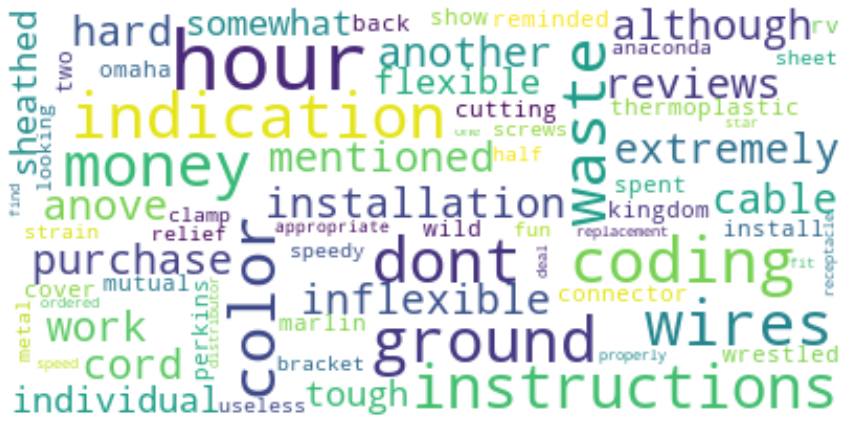

In [ ]:
import matplotlib.pyplot as plt
all_words2 = Bag_Of_Words(ListWords)
ax = plt.figure(figsize=(15, 10))

# generate a word cloud image
wordcloud = WordCloud(background_color='white', max_font_size=40).generate(' '.join(all_words2.keys()))

# display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
print(len(all_words2))

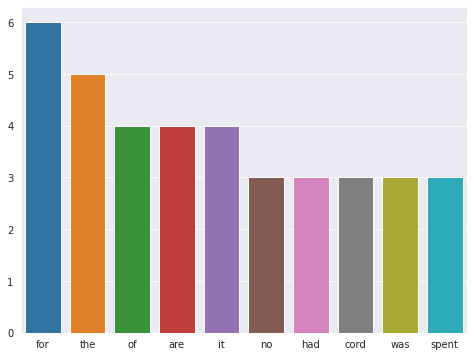

In [ ]:
plt.figure(figsize=(8, 6))
import seaborn as sns
from sklearn.manifold import TSNE
count = []
words = []
for w in all_words2.most_common(10):
    count.append(w[1])
    words.append(w[0])
sns.set_style('darkgrid')
sns.barplot(words, count)

## 높은 별점 분석

In [ ]:
prod_high = prod[(prod['rating'] >= 3)]
prod_high

,rating,reviewer_id,product_id,unix_review_time,category,description,also_buy,brand,main_cat,price,review_text,rating_class,time,clean_text,year,review_length
1,5,A2OXDRWBASV91Y,B00004SQHD,1366416000,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,complete package I like the fact that the wire...,good,2013-04-20,complete package like the fact that the wire e...,2013,33
2,5,A2KG6AWJSWILPR,B00004SQHD,1363392000,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,Perfect Fit Needed another couple of feet with...,good,2013-03-16,perfect fit needed another couple of feet with...,2013,25
3,5,A2CBE6VYOARZN4,B00004SQHD,1487030400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,Everything works Good quality at a reasonable ...,good,2017-02-14,everything works good quality at reasonable price,2017,8
4,5,AVKOTZD5ZIOX5,B00004SQHD,1482278400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,50 amp cable Planning on hooking this to my RV,good,2016-12-21,amp cable planning on hooking this to my rv,2016,10
5,5,A33DUVUIC7G553,B00004SQHD,1460678400,"['Appliances', 'Parts & Accessories', 'Range P...",['Coleman Cable 09045 5-Foot Range Cord Made o...,[],Coleman Cable,Tools & Home Improvement,$1.41,"Good range cord, standard nema 14-50p fits wit...",good,2016-04-15,good range cord standard nema fits with nema t...,2016,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438817,5,A32KK5HF8A9NZG,B000BQY9RI,1449360000,"['Appliances', 'Parts & Accessories', 'Dryer P...",['Coleman Cable 09726 16/3 Appliance Replaceme...,[],Coleman Cable,Tools & Home Improvement,$12.18,Nice cable Very heavy duty cord. Does exactly...,good,2015-12-06,nice cable very heavy duty cord does exactly w...,2015,22
438818,3,AHLH2PGB9ANFH,B000BQY9RI,1369785600,"['Appliances', 'Parts & Accessories', 'Dryer P...",['Coleman Cable 09726 16/3 Appliance Replaceme...,[],Coleman Cable,Tools & Home Improvement,$12.18,Bad Quality I got a generic one from my local ...,good,2013-05-29,bad quality got generic one from my local hard...,2013,98
447389,5,A1AO741SK2QMA4,B0002YUG0S,1489104000,"['Appliances', 'Parts & Accessories', 'Dryer P...",['Coleman Cable 09156 10/4-Gauge SRDT 30-Amp D...,[],Coleman Cable,Tools & Home Improvement,$18.55,"It works. Seems sturdy, only needed a screwdri...",good,2017-03-10,it works seems sturdy only needed screwdriver ...,2017,39
447390,5,A213YLUAJYQAPR,B0002YUG0S,1432512000,"['Appliances', 'Parts & Accessories', 'Dryer P...",['Coleman Cable 09156 10/4-Gauge SRDT 30-Amp D...,[],Coleman Cable,Tools & Home Improvement,$18.55,"Five Stars Very easy to connect, and works per...",good,2015-05-25,five stars very easy to connect and works perf...,2015,11


In [ ]:
ListWords = []
for m in prod_high['clean_text']:
    n = RegExpTokenizer(str(m))
    ListWords.append(n)
print(ListWords[1])

# All words
from nltk import FreqDist
def Bag_Of_Words(ListWords):
    all_words = []
    for m in ListWords:
        for w in m:
            all_words.append(w.lower())
    all_words3 = FreqDist(all_words)
    return all_words3

['perfect', 'fit', 'needed', 'another', 'couple', 'of', 'feet', 'with', 'new', 'dryer', 'perfect', 'fit', 'gives', 'you', 'more', 'options', 'then', 'the', 'shorter', 'cords', 'normally', 'sold']


675


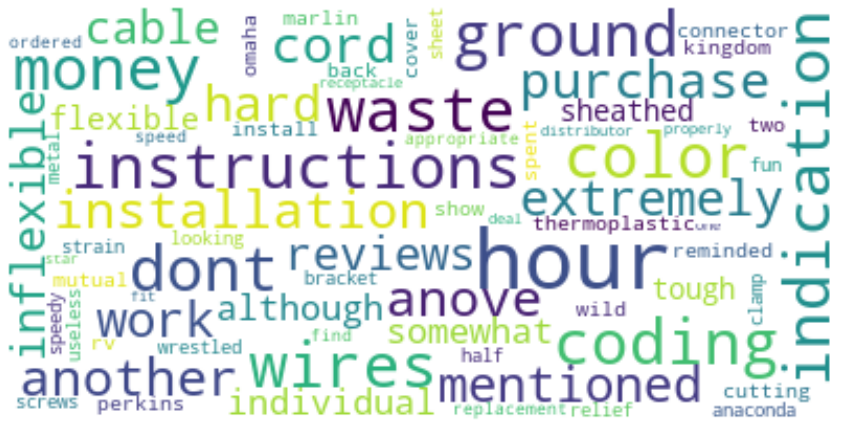

In [ ]:
all_words3 = Bag_Of_Words(ListWords)
ax = plt.figure(figsize=(15, 10))

# generate a word cloud image
wordcloud = WordCloud(background_color='white', max_font_size=40).generate(' '.join(all_words2.keys()))

# display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
print(len(all_words3))

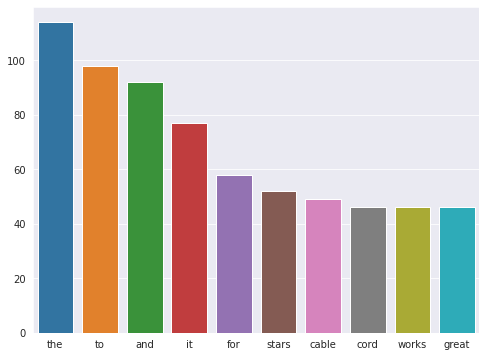

In [ ]:
plt.figure(figsize=(8, 6))
import seaborn as sns
from sklearn.manifold import TSNE
count = []
words = []
for w in all_words3.most_common(10):
    count.append(w[1])
    words.append(w[0])
sns.set_style('darkgrid')
sns.barplot(words, count)

## 기타 분석

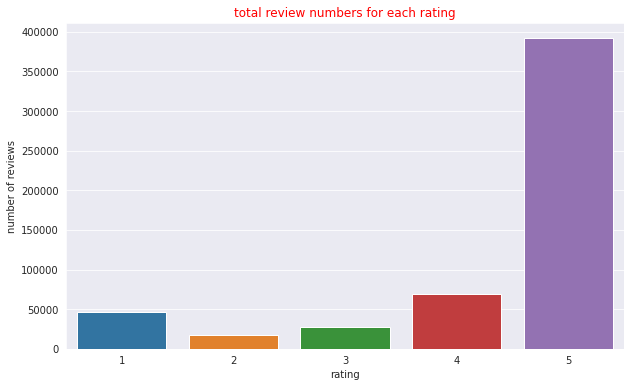

5    392000
4     69283
1     46316
3     27161
2     17582
Name: rating, dtype: int64

In [ ]:
# total numbers of ratings for each rating
plt.figure(figsize=(10, 6))
sns.countplot(df['rating'])
plt.title('total review numbers for each rating', color='r')
plt.xlabel('rating')
plt.ylabel('number of reviews')
plt.show()

# customer totals for each rating class
df['rating'].value_counts()

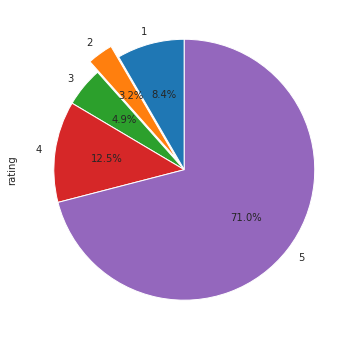

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
df.groupby('rating').rating.count()
df.groupby('rating').rating.count().plot(kind='pie',autopct='%1.1f%%',startangle=90,explode=(0,0.1,0,0,0))

In [ ]:
word_count = []
for s1 in df.review_text:
    word_count.append(len(str(s1).split()))

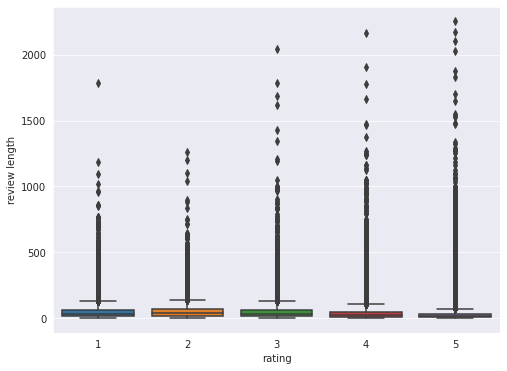

In [ ]:
plt.figure(figsize=(8, 6))

sns.boxplot(x='rating', y=word_count, data=df)
plt.xlabel('rating')
plt.ylabel('review length')
plt.show()

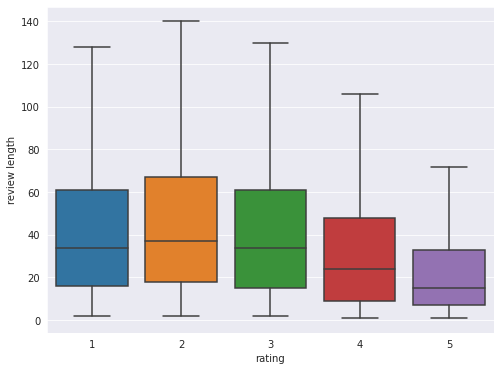

In [ ]:
# remove the outliers
plt.figure(figsize=(8, 6))

sns.boxplot(x='rating', y=word_count, data=df, showfliers=False)
plt.xlabel('rating')
plt.ylabel('review length')
plt.show()

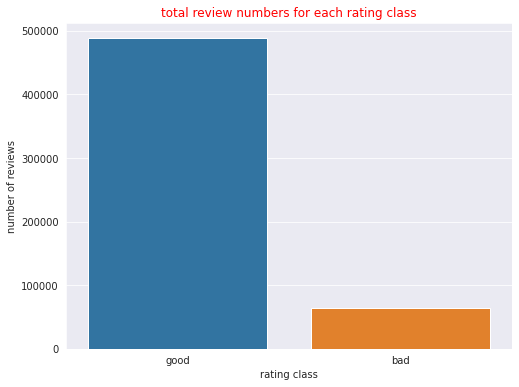

good    488444
bad      63898
Name: rating_class, dtype: int64

In [ ]:
# total review numbers for each rating class
plt.figure(figsize=(8, 6))
sns.countplot(df['rating_class'])
plt.title('total review numbers for each rating class', color='r')
plt.xlabel('rating class')
plt.ylabel('number of reviews')
plt.show()

# customer totals for each rating class
df['rating_class'].value_counts()

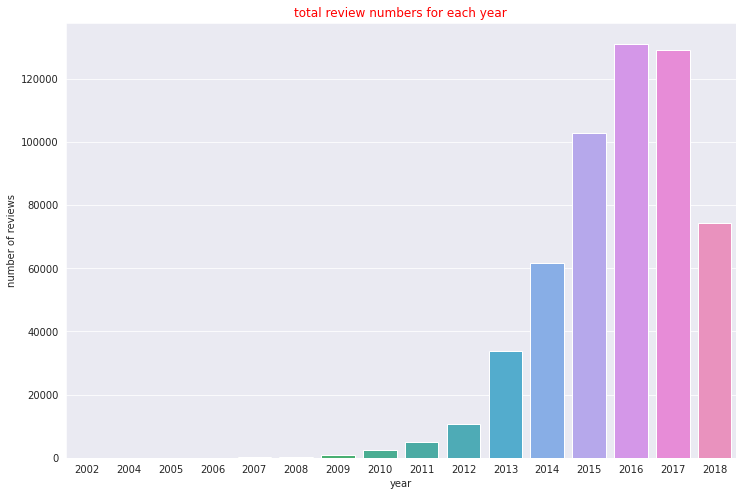

2016    131102
2017    129111
2015    102753
2018     74328
2014     61732
2013     33673
2012     10806
2011      5086
2010      2336
2009       789
2008       348
2007       204
2006        48
2005        22
2004         3
2002         1
Name: year, dtype: int64

In [ ]:
# total review for every year
plt.figure(figsize=(12, 8))
sns.countplot(df['year'])
plt.title('total review numbers for each year', color='r')
plt.xlabel('year')
plt.ylabel('number of reviews')
plt.show()

# customer totals for each rating class
df['year'].value_counts()

In [ ]:
# How many unique customers do we have in the dataset?
print(f'number of unique customers: {len(df.reviewer_id.unique())}')

number of unique customers: 483143


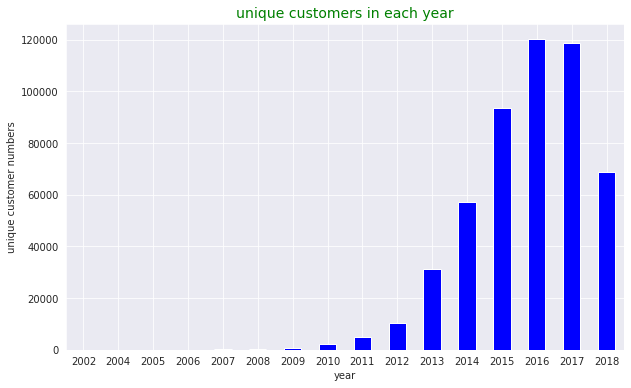

year
2002         1
2004         3
2005        22
2006        48
2007       202
2008       342
2009       778
2010      2286
2011      4948
2012     10310
2013     31388
2014     57202
2015     93700
2016    120215
2017    118789
2018     68905
Name: reviewer_id, dtype: int64


In [ ]:
# How many unique customers in each year?
unique_cust = df.groupby('year')['reviewer_id'].nunique()

# visualize
plt.figure(figsize=(10, 6))
unique_cust.plot(kind='bar', rot=0, color='b')
plt.title('unique customers in each year', color='g', size=14)
plt.xlabel('year')
plt.ylabel('unique customer numbers')
plt.show()

print(unique_cust)

In [ ]:
# how many unique customers do we have in each rating class?

# unique customers for each rating class
a = list(df.groupby(['rating_class'])['reviewer_id'].unique())

# number of customers
a2 = [len(a[0]), len(a[1])]

# number of reviews for each rating class
b = list(df['rating_class'].value_counts())

uniq_cust_rate = pd.DataFrame({'rating_class': ['bad', 'good'],
                               'number_of_customers': a2,
                               'number_of_reviews': sorted(b)})
print(uniq_cust_rate)

  rating_class  number_of_customers  number_of_reviews
0          bad                62148              63898
1         good               427085             488444


In [ ]:
# number of unique products
print(f'number of unique products: {len(df.product_id.unique())}')

number of unique products: 28260


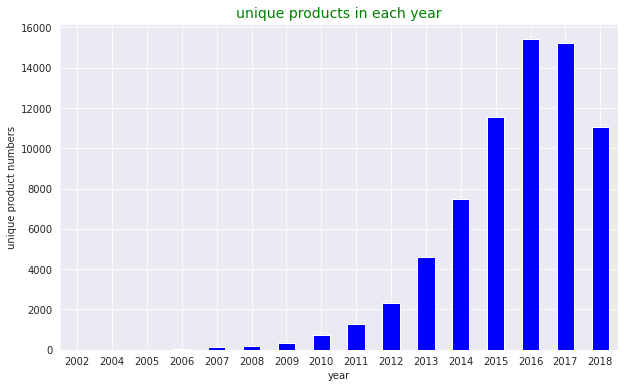

year
2002        1
2004        3
2005       11
2006       25
2007      122
2008      178
2009      314
2010      711
2011     1260
2012     2301
2013     4620
2014     7461
2015    11574
2016    15412
2017    15221
2018    11068
Name: product_id, dtype: int64


In [ ]:
# How many unique products in each year?
unique_prod = df.groupby('year')['product_id'].nunique()

# plot unique product numbers in each year
plt.figure(figsize=(10, 6))
unique_prod.plot(kind='bar', color='b', rot=0)
plt.title('unique products in each year', color='g', size=14)
plt.xlabel('year')
plt.ylabel('unique product numbers')
plt.show()

print(unique_prod)

Text(0, 0.5, 'number of reviews')

<Figure size 1080x576 with 0 Axes>

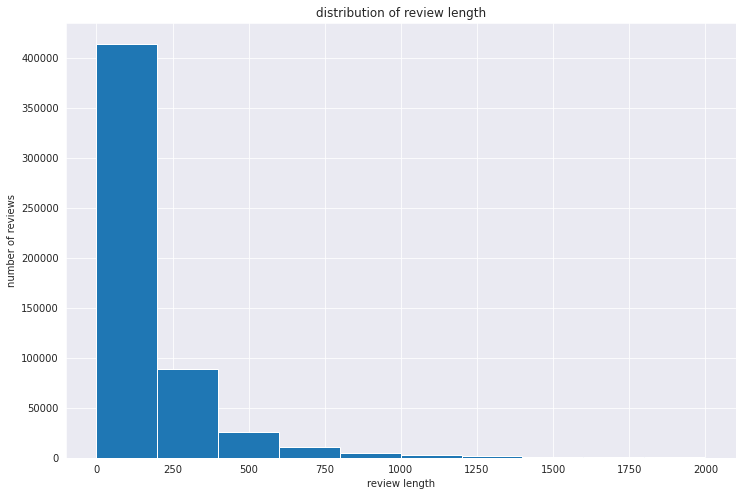

In [ ]:
# plot distribution of review length
plt.figure(figsize=(15, 8))

review_length = df['clean_text'].dropna().map(lambda x: len(x))
plt.figure(figsize=(12, 8))
review_length.loc[review_length < 2000].hist()
plt.title('distribution of review length')
plt.xlabel('review length')
plt.ylabel('number of reviews')

In [ ]:
# how do the rating classes change for each year?
# create a dataframe which shows the relationship between review numbers and rating classes for each year


feature = df.groupby('year').agg({'rating': ['size', 'sum', 'mean']})
feature_columns = [' '.join(col).strip() for col in feature.columns.values]
feature = feature.reset_index()
feature['total_reviews'] = feature['rating']['size']
feature['relevant_rating_number'] = feature['rating']['sum']
feature['rating_mean'] = feature['rating']['mean']*100
feature['total_percentage'] = (feature['relevant_rating_number'] / 130133)*100
feature

year  rating          ... relevant_rating_number rating_mean total_percentage
            size     sum  ...                                                    
0   2002       1       1  ...                      1  100.000000         0.000768
1   2004       3      10  ...                     10  333.333333         0.007684
2   2005      22      87  ...                     87  395.454545         0.066855
3   2006      48     192  ...                    192  400.000000         0.147541
4   2007     204     811  ...                    811  397.549020         0.623209
5   2008     348    1410  ...                   1410  405.172414         1.083507
6   2009     789    3198  ...                   3198  405.323194         2.457486
7   2010    2336    9865  ...                   9865  422.303082         7.580706
8   2011    5086   21565  ...                  21565  424.007078        16.571508
9   2012   10806   46499  ...                  46499  430.307237        35.731905
10  2013   33673  145770  ...                 145770  432.898762       112.016168
11  2014   61732  271435  ...                 271435  439.699022       208.582758
12  2015  102753  451592  ...                 451592  439.492764       347.023430
13  2016  131102  572246  ...                 572246  436.489146       439.739344
14  2017  129111  558056  ...                 558056  432.229632       428.835115
15  2018   74328  317358  ...                 317358  426.969648       243.872039

[16 rows x 8 columns]

In [ ]:
feature = feature.drop(['rating'], axis=1)

In [ ]:
feature

,year,total_reviews,relevant_rating_number,rating_mean,total_percentage
,,,,,
0,2002,1,1,100.000000,0.000768
1,2004,3,10,333.333333,0.007684
2,2005,22,87,395.454545,0.066855
3,2006,48,192,400.000000,0.147541
4,2007,204,811,397.549020,0.623209
5,2008,348,1410,405.172414,1.083507
6,2009,789,3198,405.323194,2.457486
7,2010,2336,9865,422.303082,7.580706
8,2011,5086,21565,424.007078,16.571508


<Figure size 864x576 with 0 Axes>

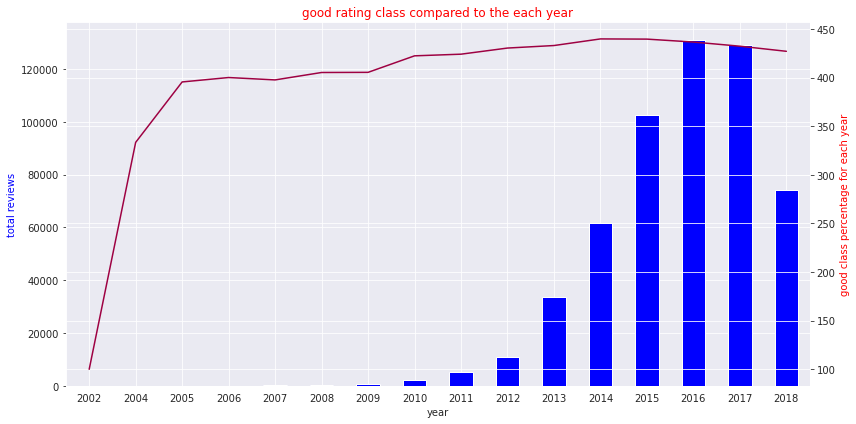

In [ ]:
# create a graph for each rating class to compare within the years
plt.figure(figsize=(12, 8))
fig0, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
feature.set_index(feature['year'], drop=True, inplace=True)
feature['total_reviews'].plot(kind='bar', stacked=True, ax=ax1, colormap='winter', rot=0)
feature['rating_mean'].plot(use_index=False,
                                      kind='line', ax=ax2, colormap='Spectral')

plt.title('good rating class compared to the each year', color='r')
ax1.set_xlabel('year')
ax1.yaxis.label.set_color('blue')
ax1.set_ylabel('total reviews')
ax2.set_ylabel('good class percentage for each year')
ax2.yaxis.label.set_color('red')
plt.tight_layout()
plt.show()

In [ ]:
df3 = df.drop(df[(df['review_length'] > 150) & (df['rating_class'] == 'good')].index)

In [ ]:
df4 = df3.drop(df3[(df3['year'] < 2010)].index)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536686 entries, 0 to 552341
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   rating            536686 non-null  int64         
 1   reviewer_id       536686 non-null  object        
 2   product_id        536686 non-null  object        
 3   unix_review_time  536686 non-null  int64         
 4   category          536686 non-null  object        
 5   description       536686 non-null  object        
 6   also_buy          536686 non-null  object        
 7   brand             532320 non-null  object        
 8   main_cat          536445 non-null  object        
 9   price             445164 non-null  object        
 10  review_text       536686 non-null  object        
 11  rating_class      536686 non-null  object        
 12  time              536686 non-null  datetime64[ns]
 13  clean_text        536686 non-null  object        
 14  year

In [ ]:
df['review_length'].describe()

count    552342.000000
mean         37.629516
std          56.944666
min           1.000000
25%           9.000000
50%          21.000000
75%          44.000000
max        2750.000000
Name: review_length, dtype: float64

In [ ]:
# create a new dataframe with clean text and rating class number
df5 = df4[['clean_text', 'rating']].reset_index()
df5.head(10)

,index,clean_text,rating
0,0,matched pigtail cord and works great just what...,5
1,1,complete package like the fact that the wire e...,5
2,2,perfect fit needed another couple of feet with...,5
3,3,everything works good quality at reasonable price,5
4,4,amp cable planning on hooking this to my rv,5
5,5,good range cord standard nema fits with nema t...,5
6,6,four stars worked great,4
7,7,very good quality used as feeder line to my ve...,5
8,8,five stars excellent,5
9,9,the cable works but was hard to maneuver and w...,3


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

In [ ]:
# initialize the countervectorizer
countVec = CountVectorizer(ngram_range=(1, 2), binary=True)

In [ ]:
# fit the clean_text to countvectorizer
countVec.fit(df5['clean_text'])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)